# 10. Spore Clusters

## Numerical experiments - Week 08/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting

## 1. Spore centroid generation

The following code computes the coordinates of a cluster of $n$ spherical spores, placing one spore at the centre of the lattice and the rest of the spores distributed evenly around it - in polar, triangular, tetrahedral, cubic, octahedral and icosahedral configurations.

In [2]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

spore_centers = setup_spore_cluster(12, L, spore_rad)

13-element Vector{Tuple{Float64, Float64, Float64}}:
 (12.5, 12.5, 12.5)
 (12.5, 9.871344439404332, 16.7532540417602)
 (12.5, 9.871344439404332, 8.2467459582398)
 (12.5, 15.128655560595668, 8.2467459582398)
 (16.7532540417602, 12.5, 15.128655560595668)
 (16.7532540417602, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 15.128655560595668)
 (15.128655560595668, 16.7532540417602, 12.5)
 (9.871344439404332, 16.7532540417602, 12.5)
 (9.871344439404332, 8.2467459582398, 12.5)
 (15.128655560595668, 8.2467459582398, 12.5)
 (12.5, 15.128655560595668, 16.7532540417602)

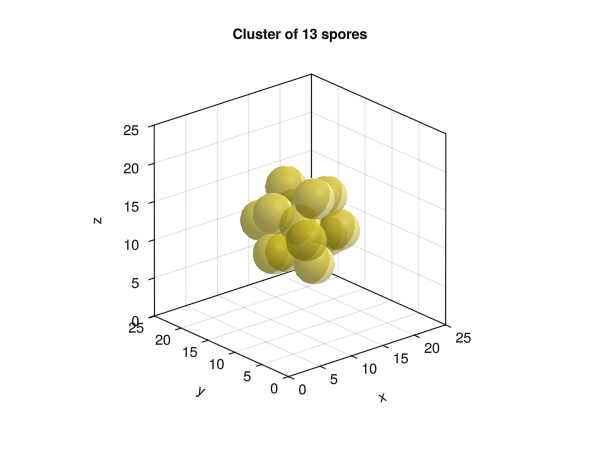

Makie.Axis3()

In [3]:
plot_spheres!(spore_centers, spore_rad, L, inline=true, title="Cluster of $(size(spore_centers)[1]) spores")

## 2. Measure of spore exposure

To measure the degree of coverage of a spore, a geometric construction is used that projects the areas of the surrounding spheres onto the central spore surface, here denoted as the sampling sphere, or sphere A. Let sphere B be a second reference sphere, with a centre positioned at a distance $d$ from the sampling sphere. One can construct a cone with a tip at the centre of the sphere A that touches sphere B tangentially. It thus intersects sphere A at a circular region, forming a spherical cap. The area of this cap can be computed by an integral over polar coordinates with a reference to the axis connecting the cenres of the two spheres:

$$
\begin{equation}
A=R^2\int_0^{2\pi}{\int_0^{\phi_0}{\sin{\phi}d{\phi}}d{\theta}},
\end{equation}
$$

where $\phi_0$ is the half-angle at the tip of the cone and defines the maximum that the vertical angle $\phi$ can reach and $\theta$ is the azimuthal angle around the reference axis. It can be noted that the farther sphere B is, the smaller its projection represented through the cap area would be. One can think of this projection as the "shadow" of sphere B onto sphere A. To capture even more detail about the proximity of surrounding spheres to the sampling sphere, each infinitesimal unit of area can be weighted by a function that depends on the projection distance between the surface areas. This can be pictured as the distance between two intersection points of a ray emanating from the centre of sphere A toward the sampled infinitesimal volume - one intersection through the surface of A and one through the surface of B. This distance can be expressed through the formula

$$
\begin{equation}
\Delta=d\cos{\phi}-\sqrt{R^2-d^2\sin^2{\phi}}-R
\end{equation}
$$

and used in a weighting function $w{(\phi)}=e^{-\Delta{(\phi)}}$, such that a weighted cap area is attained:

$$
\begin{equation}
A_w=R^2\int_0^{2\pi}{\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}d{\theta}}.
\end{equation}
$$

This has the property that the "shadow" intensity becomes 1 at $\Delta=0$ and decays to zero with increasing distance. Since the integrand is independent of the azimuthal angle $\theta$, the integral simplifies to

$$
\begin{equation}
A_w=2\pi R^2\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}.
\end{equation}
$$

The maximum limit for $\phi$ can be computed as $\phi_0=\arcsin{\frac{R}{d}}$. Thus, writing out the complete integral and summing for $M$ neighbours, one can obtain a measure for the surface coverage of a spore:

$$
\begin{equation}
Q=2\pi R^2\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}},
\end{equation}
$$

where $d_i$ are the corresponding distances from the sampling sphere centre to the neighbour centres. Furthermore, the cumulative surface coverage can be made relative to the total surface area of the spore by dividing by $4\pi R^2$:

$$
\begin{equation}
Q=\frac{1}{2}\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}}.
\end{equation}
$$

It is hereby assumed that only spheres that have an unobstructed "field of view" from the sampling sphere are considered. In the current experiments, these are furthermore only spheres that are directly adjacent to the central sphere.

The measure of coverage $Q$ is computed using the Julia `QuadGK` package and is demonstrated for different neighbour configurations.

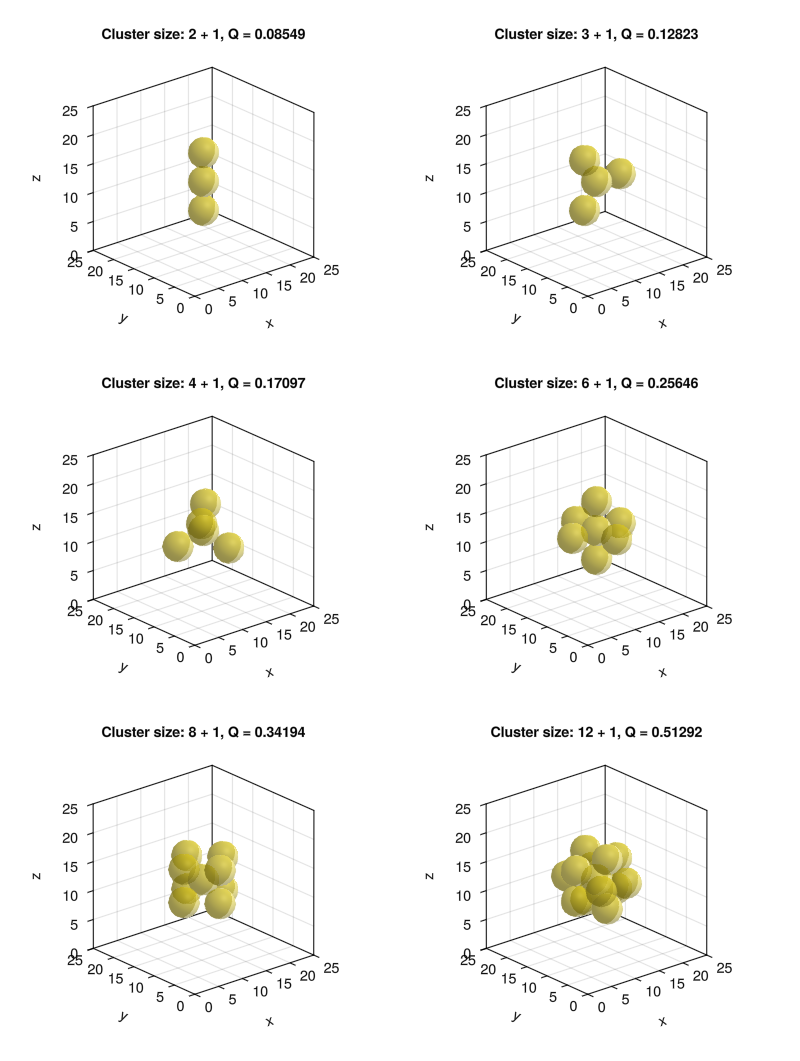

GLMakie.Screen(...)

In [4]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

n_nbrs = [2, 3, 4, 6, 8, 12]

plot_spore_clusters(n_nbrs, spore_rad, L)

Apart from the fully symmetrical neighbour configurations, asymmetrical arrangements of the spores are also investigated by omitting all spores in the upper half-space of the cluster. Apart from implementing neighbourhood counts which were not possible in the regular clusters, this is helpful for verifying whether the same number of neighbours in a symmetrical and an asymmetrical arrangement has the same influence on diffusion inhibition.

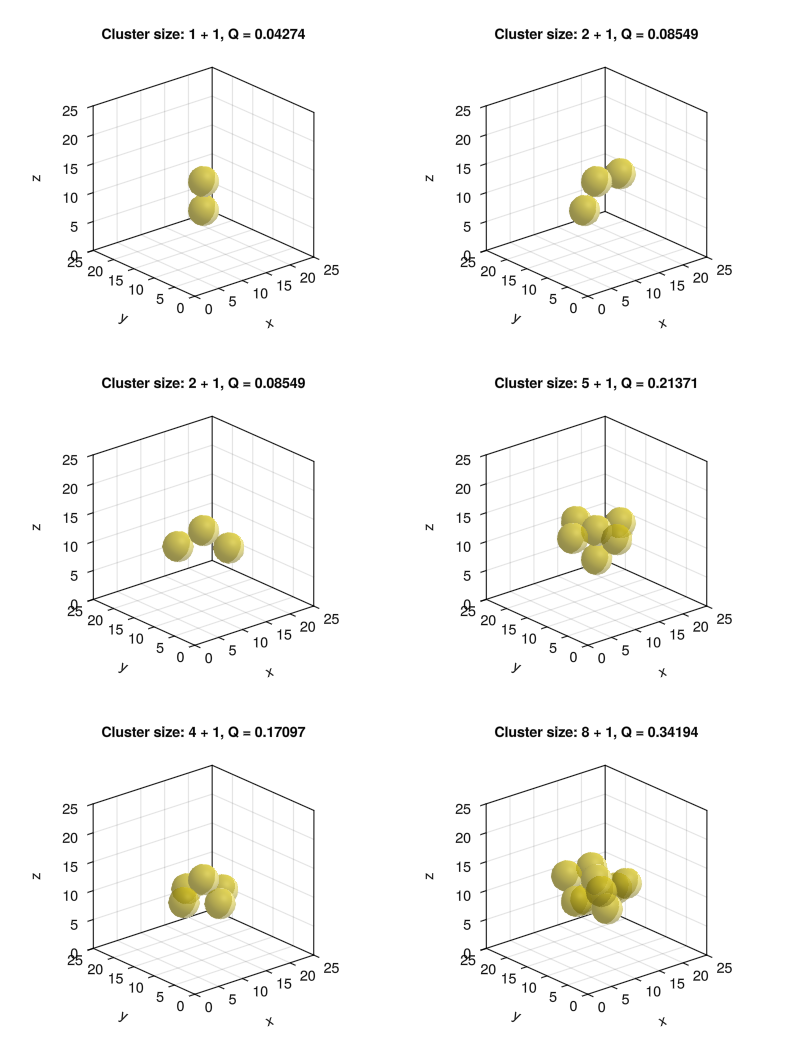

GLMakie.Screen(...)

In [3]:
plot_spore_clusters(n_nbrs, spore_rad, L; cut_half=true)

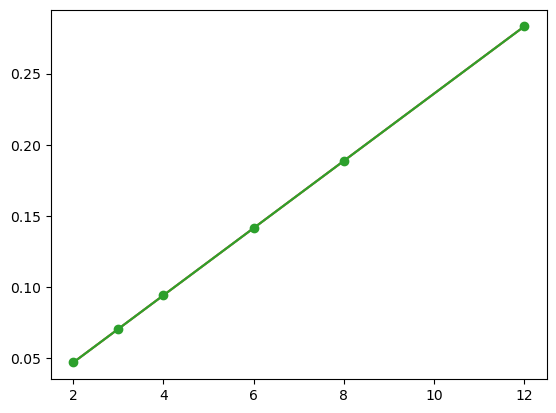

In [15]:
plot([2,3,4,6,8,12],[0.04717,0.07075,0.09434,0.1415,0.18867,0.28301], marker="o")
gcf()

## 3. Diffusion test

A diffusion process in a multi-spore cluster is briefly demonstrated in a linear cluster of 3 for a time-frame of 100 seconds. An absorbing boundary condition is defined, such that the concentrations at the edges of the domain are always zero.

In [7]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# Diffusion parameters
dt = 0.01
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

# Spore centers
sp_cen_indices = setup_spore_cluster(2, N, spore_rad / dx, false)

# Run simulation
n_save_frames = 100
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution (high-resolution): ", c_numerical[end])

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 149.99999999999997, Db*dt/dx2 = 1.3376765347559088e-5, Dcw*dt/dx2 = 6.68838297200931e-6
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Frame 39 saved.
Frame 40 saved.
Frame 41 saved.
Frame 42 saved.
Frame 43 saved.
Frame 44 saved.
Frame 45 saved.
Frame 46 save

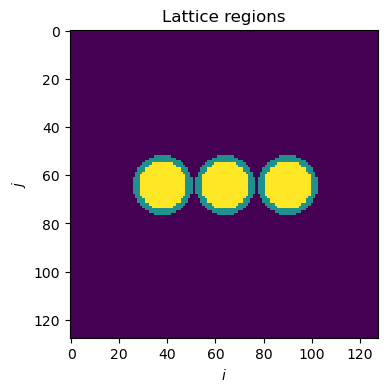

In [8]:
plot_lattice_regions(region_ids)

Plotting frames: [1, 26, 51, 76]


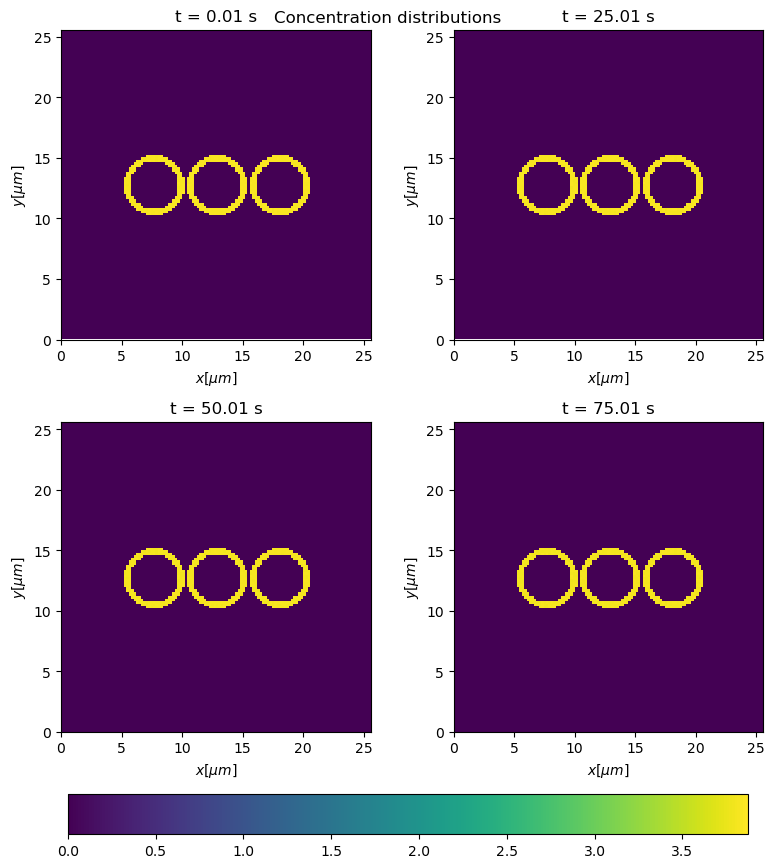

In [9]:
frame_indices = collect(1:round(Int, size(c_frames)[1] / 4):size(c_frames)[1]-1)
plot_concentration_lattice(c_frames, dx, frame_indices=frame_indices, times=times_numerical, title="Concentration distributions")

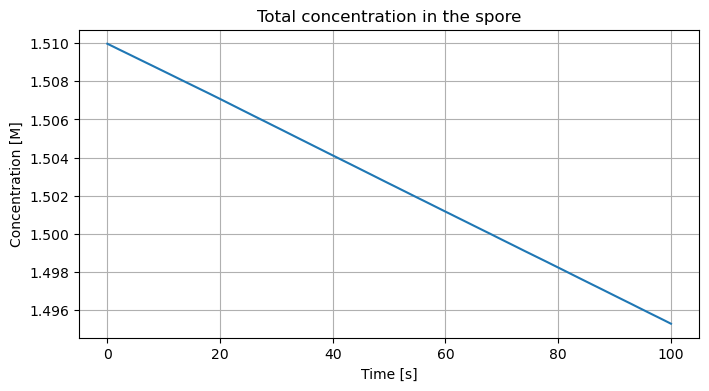

In [10]:
plot_concentration_evolution(c_numerical, times_numerical)

## 4. Diffusion experiments with two extremes

### 4.1. Slow release

To establish whether the spore coverage has any significant effect on the diffusion of the inhibitor, the two extreme configurations: a single spore and a fully surrounded spore with 12 neighbours, are used in a high-resolution diffusion simulation. The usual time-frame of 4 hours is used.

In [11]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ms[end])

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Frame 39 saved.
Frame 40 saved.
Frame 41 saved.
Frame 42 saved.
Frame 43 saved.
Frame 44 saved.
Frame 45 saved.
Frame 46 saved

Plotting frames: [1, 26, 51, 76]


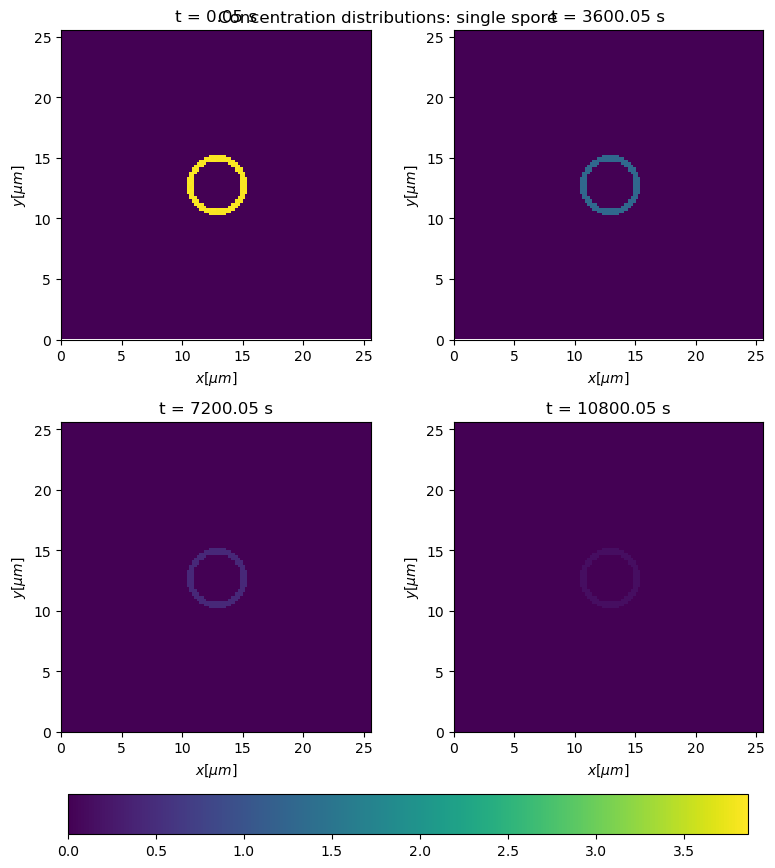

In [12]:
frame_indices = collect(1:round(Int, size(c_frames_ss)[1] / 4):size(c_frames_ss)[1]-1)
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Concentration distributions: single spore")

[25, 50, 75, 100]
Plotting frames: [26, 51, 76, 101]


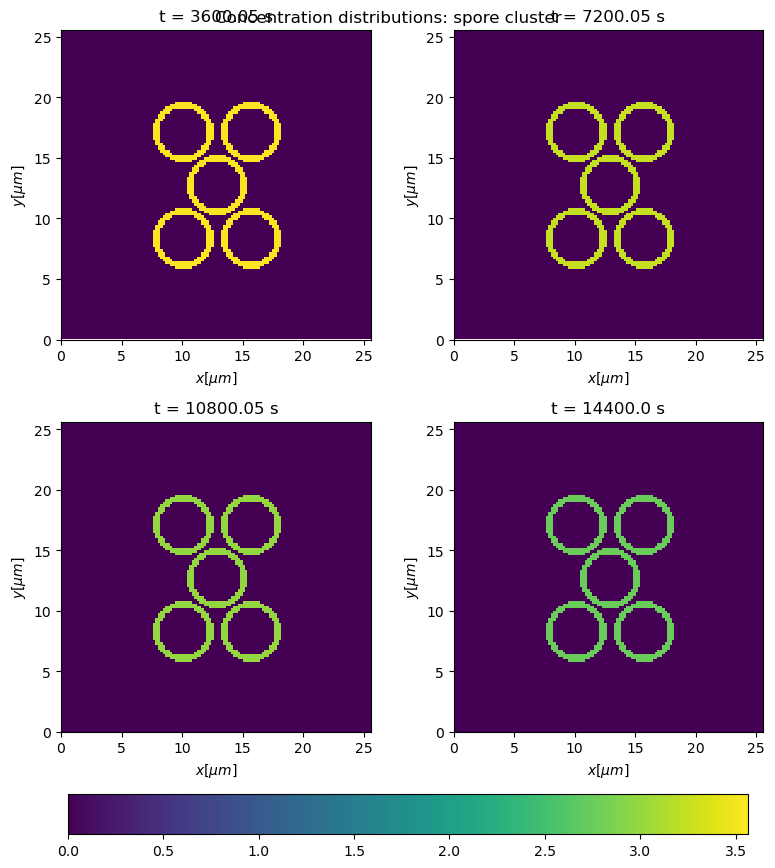

In [13]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 4):round(Int, size(c_frames_ms)[1] / 4):size(c_frames_ms)[1]+1).+1
println(frame_indices.-1)
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Concentration distributions: spore cluster")

Fitted exponential: (1.5100054544024641, -0.00030039698056287675)
Fitted exponential: (1.509854452644602, -2.3093861469187907e-5)


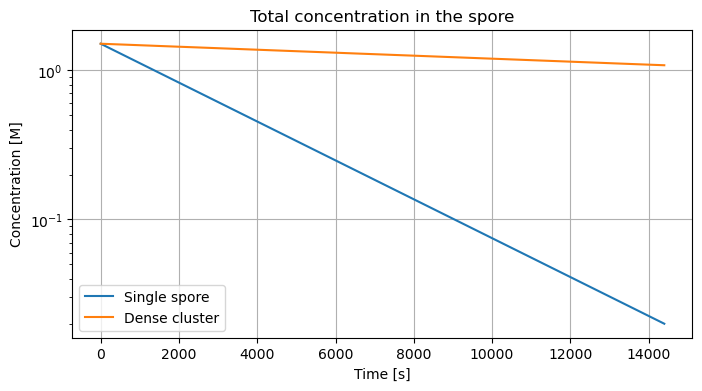

In [17]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true, fit_exp=true)

The much slower decay of the concentration in the central spore of the dense cluster indicates that the obstacles imposed by the surrounding spores have a significant effect on the depletion of the inhibitor.

### 4.2. Fast release

A relevant control experiment that can elucidate the role of spatial obstacles around the spore is to conduct analogical tests with disregard of the slow release, i.e. using the same diffusion coefficient within the medium and inside the cell wall. Since the absorbing boundary prohibits any finite-size saturation effects, a lingering concentration in the spore would indicate that the impermeable spore interiors have a severe limiting effect on the escape of inhibitor molecules.

In [29]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100#14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.0001
Db = D # same as diffusion through medium
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx, false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ms[end])

Using D = 600, Db = 600, Dcw = 600.0
D*dt/dx2 = 1.4999999999999998, Db*dt/dx2 = 1.4999999999999998, Dcw*dt/dx2 = 1.4999999999999998
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Frame 39 saved.
Frame 40 saved.
Frame 41 saved.
Frame 42 saved.
Frame 43 saved.
Frame 44 saved.
Frame 45 saved.
Frame 46 saved.
Frame 47 saved.
Frame 48 saved.
Fr

Plotting frames: [1, 26, 51, 76]


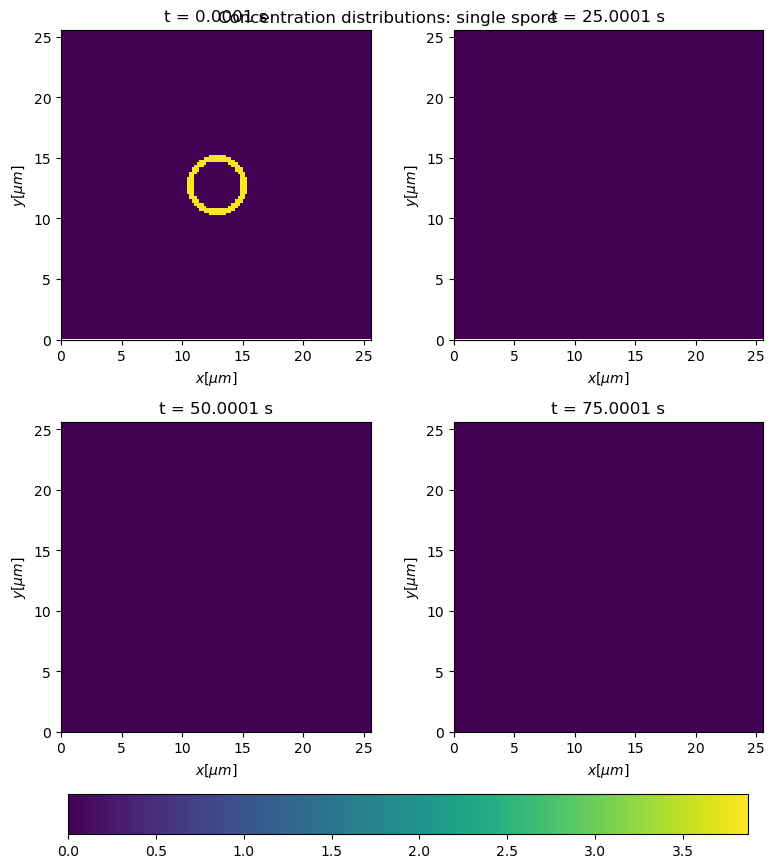

In [30]:
frame_indices = collect(1:round(Int, size(c_frames_ss)[1] / 4):size(c_frames_ss)[1]-1)
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Concentration distributions: single spore")

[25, 50, 75, 100]
Plotting frames: [26, 51, 76, 101]


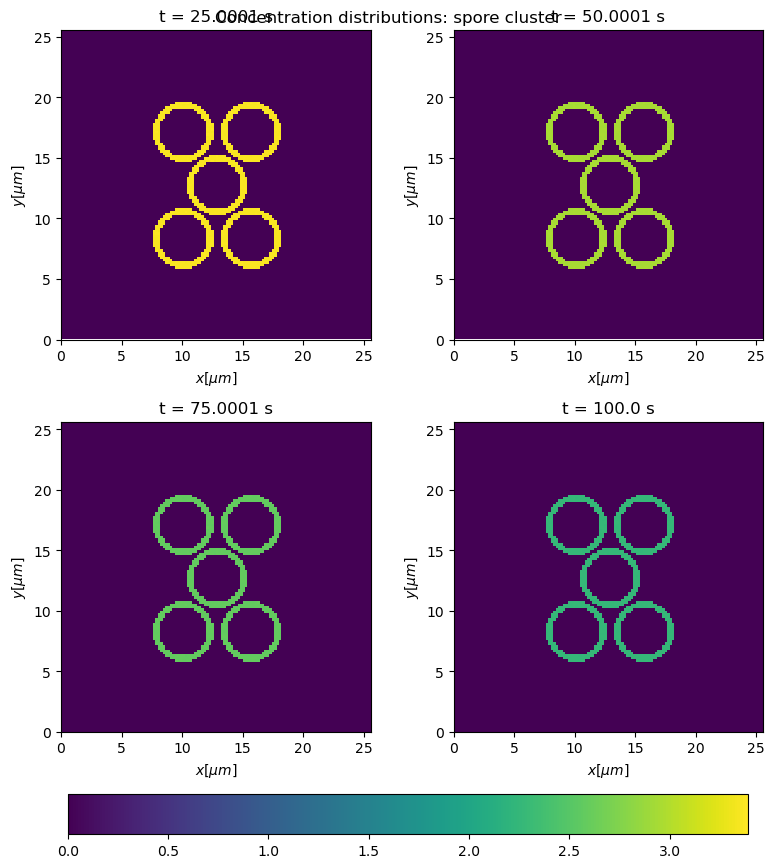

In [31]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 4):round(Int, size(c_frames_ms)[1] / 4):size(c_frames_ms)[1]+1).+1
println(frame_indices.-1)
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Concentration distributions: spore cluster")

Fitted exponential: (NaN, NaN)
Fitted exponential: (1.5098752728259457, -0.005295539374407294)


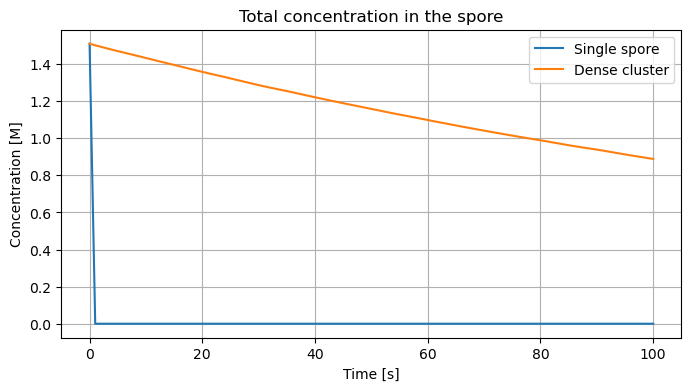

In [34]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=false, fit_exp=true)

## 5. Functional relationship between spore coverage and decay exponent

Acknowledging the difference in the exponential decay of the